In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib as mpl

In [5]:
dat = pd.read_csv('train.csv', index_col='row_id')
dat.head(10)

,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01 00:00:00,0,0,EB,70
1,1991-04-01 00:00:00,0,0,NB,49
2,1991-04-01 00:00:00,0,0,SB,24
3,1991-04-01 00:00:00,0,1,EB,18
4,1991-04-01 00:00:00,0,1,NB,60
5,1991-04-01 00:00:00,0,1,SB,58
6,1991-04-01 00:00:00,0,1,WB,26
7,1991-04-01 00:00:00,0,2,EB,31
8,1991-04-01 00:00:00,0,2,NB,49


In [19]:
def preprocess(dat):
    time_mapper = {}
    ii = 0
    for h in range(24):
        for mm in ['00','20','40']:
            hh = '{0:02d}'.format(h)
            time_mapper[hh+':'+mm] = ii
            ii += 1

    dat['unique'] = dat['x'].astype(str) + dat['y'].astype(str) + dat['direction']
    uniques = dat['unique'].unique()
    dat['day'] = pd.to_datetime(dat['time']).dt.weekday
    dat['time_stamp'] = dat['time'].apply(lambda x:time_mapper[x.split()[1][:5]])

    tmp = dat.groupby(['unique','day','time_stamp']).agg({'congestion':np.median})
    median_mapper = tmp.to_dict()['congestion']
    dat['median'] = dat.apply(lambda x: \
                              median_mapper[x['unique'],x['day'],x['time_stamp']], axis=1)
    dat['congestion-median'] = dat['congestion'] - dat['median']

    
#     congestions = dat[['unique','congestion','time']].set_index('time')
    congestions = dat[['unique','congestion-median','time']].set_index('time')
    congestions = congestions.groupby(['unique','time']).mean().unstack('unique')
    congestions.columns = congestions.columns.droplevel(0)
     
    congestions['time_stamp'] = \
       pd.Series(congestions.index).apply(lambda x:time_mapper[x.split()[1][:5]]).values
    congestions['day'] = \
       pd.to_datetime(pd.Series(congestions.index)).dt.weekday.values
    
    return congestions, uniques

In [20]:
congestions, uniques = preprocess(dat)

In [21]:
congestions.iloc[0], uniques

(unique
 00EB          35.0
 00NB          20.0
 00SB           0.0
 01EB           1.0
 01NB          -3.0
               ... 
 23SB           2.0
 23SW           7.0
 23WB          -8.0
 time_stamp     0.0
 day            0.0
 Name: 1991-04-01 00:00:00, Length: 67, dtype: float64,
 array(['00EB', '00NB', '00SB', '01EB', '01NB', '01SB', '01WB', '02EB',
        '02NB', '02SB', '02WB', '03EB', '03NB', '03NE', '03SB', '03SW',
        '03WB', '10EB', '10NB', '10NE', '10SB', '10SW', '10WB', '11EB',
        '11NB', '11SB', '11WB', '12EB', '12NB', '12NE', '12SB', '12SW',
        '12WB', '13EB', '13NB', '13NE', '13SB', '13SW', '13WB', '20EB',
        '20NB', '20SB', '20WB', '21EB', '21NB', '21NE', '21NW', '21SB',
        '21SE', '21SW', '21WB', '22EB', '22NB', '22NE', '22NW', '22SB',
        '22SE', '22SW', '22WB', '23EB', '23NB', '23NE', '23SB', '23SW',
        '23WB'], dtype=object))

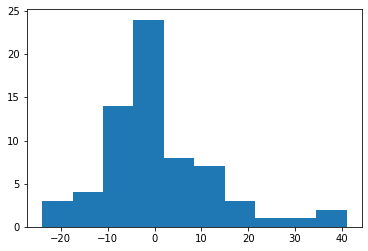

In [23]:
plt.hist(congestions.iloc[0].values);

In [8]:
congestions.iloc[0], uniques

(unique
 00EB          70.0
 00NB          49.0
 00SB          24.0
 01EB          18.0
 01NB          60.0
               ... 
 23SB          70.0
 23SW          29.0
 23WB          26.0
 time_stamp     0.0
 day            0.0
 Name: 1991-04-01 00:00:00, Length: 67, dtype: float64,
 array(['00EB', '00NB', '00SB', '01EB', '01NB', '01SB', '01WB', '02EB',
        '02NB', '02SB', '02WB', '03EB', '03NB', '03NE', '03SB', '03SW',
        '03WB', '10EB', '10NB', '10NE', '10SB', '10SW', '10WB', '11EB',
        '11NB', '11SB', '11WB', '12EB', '12NB', '12NE', '12SB', '12SW',
        '12WB', '13EB', '13NB', '13NE', '13SB', '13SW', '13WB', '20EB',
        '20NB', '20SB', '20WB', '21EB', '21NB', '21NE', '21NW', '21SB',
        '21SE', '21SW', '21WB', '22EB', '22NB', '22NE', '22NW', '22SB',
        '22SE', '22SW', '22WB', '23EB', '23NB', '23NE', '23SB', '23SW',
        '23WB'], dtype=object))

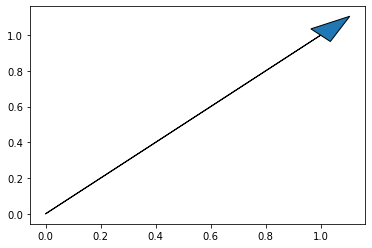

In [9]:
plt.arrow(0,0,1,1,head_width=0.1)

color refers to 
https://stackoverflow.com/questions/18748328/plotting-arrows-with-different-color-in-matplotlib

movie refers to
https://www.geeksforgeeks.org/moviepy-creating-animation-using-matplotlib/

In [30]:
class DrawNet():
    
    def __init__(self, p=0.1):
        ''' points at 8 corners around a node '''
        d = 1.0 - 4*p
        self.shifts = {
            'EB': ((2*p, -1*p), (d, 0)),
            'WB': ((-2*p, 1*p), (-d, 0)),
            'NB': ((1*p, 2*p), (0, d)),
            'SB': ((-1*p, -2*p), (0, -d)),
            'NE': ((2*p, 1*p), (d, d)),
            'SE': ((1*p, -2*p), (d, -d)),
            'SW': ((-2*p, -1*p), (-d, -d)),
            'NW': ((-1*p, 2*p), (-d, d))
        }
#         self.cnorm = colors.Normalize(vmin=0, vmax=100)
        self.cnorm = colors.Normalize(vmin=-30, vmax=30)
        self.scalarMap = plt.cm.ScalarMappable(norm=self.cnorm, cmap=plt.cm.plasma)
    
    def makemovie(self, dat):
        fig, ax = plt.subplots(1, figsize=(5,5))
        axc = fig.add_axes([1.1, 0.10, 0.05, 0.85])
        for i in range(200):
            self.drawnet(dat.iloc[i], uniques, fig, ax, axc)
            plt.savefig('{0:03d}demedian.png'.format(i))
        
    def drawnet(self, series, uniques, fig, ax, axc):
        for unique in uniques:
            self.drawarrow(unique, series[unique], ax)
        ax.set_title(f"time = {series['time_stamp']} day = {series['day']}")
        mpl.colorbar.ColorbarBase(axc, cmap=plt.cm.plasma,
                                norm=self.cnorm,orientation='vertical')
    
    def drawarrow(self, unique, val, ax):
        x = np.int32(unique[0])
        y = np.int32(unique[1])
        x += self.shifts[unique[2:4]][0][0]
        y += self.shifts[unique[2:4]][0][1]
        dx = self.shifts[unique[2:4]][1][0]
        dy = self.shifts[unique[2:4]][1][1]
        ax.arrow(x,y,dx,dy,
                 color=self.scalarMap.to_rgba(val),
                 head_width=0.1, length_includes_head=True)

In [31]:
draw = DrawNet()

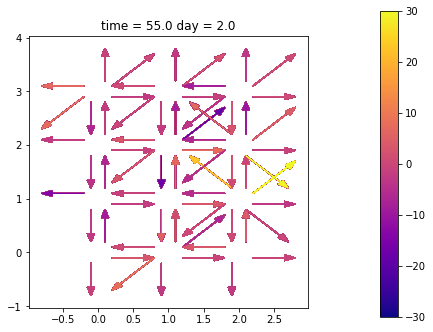

In [32]:
draw.makemovie(congestions)

In [ ]:
congestions.iloc[0]

In [ ]:
fig = 
draw.drawnet(congestions.iloc[0],uniques,ax)

In [ ]:
import moviepy